##  Customer Complaint Classification  Model
##### Author: Kevin Okiah
**6/8/2019**

This notebook is for describes the process of selecting and building of Classification model to predict the product group for customer complaint for proper routing.

**Key take aways**

1. Since the classes are highly imbalanced with minority target class being complaints for **money transfer** `4731 complaints` and majority target class being **Credit Reporting** `73991`, data sampling is pursued to prevent overfitting on the majority class. After splitting the data into 70% Training set and 30% Test set, the Training Set is Randomly Under Sampled to balance the classes to the minority class count. The resulting training set has `3277` observations (Product Group Complaints) for each of the 7 product Groups. 
2. Four Classifiers; Naive Bayes, Random Forest, Logistic Regression and Linear SVC and evaluated in terms of `Accuracy`. Linear Support Vector Classifier outperforms the other three with best 10Kfold Accuracy of 82.7%.
3. The Selected SVC results in final test accuracy of 80%. LinearSVC is evaluated on how well in predicts the Product Groups using Precision and Recall. The Final LinearSVC has a High recall and low precision for a `credit_reporting` and `debt_collection` product groups meaning the classifier is too conservative. The LinearSVC classifier has has high recall and low precision for `bank_service`, `credit_card`, `loan` and `money_transfer` meaning that the classifier is biased to that class. The classifier performs ideally in prediction of `mortgage` complaints where is has high recall and high precision which is what we seek.


In [7]:
#visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Manipulation and Statistics
import pandas as pd
import numpy as np
import pickle

#machine learning
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

from  collections import Counter


import warnings
warnings.filterwarnings('ignore')

In [8]:
seed=1000 # set for reproducability

In [9]:
#load pickled data
with open('data/modelingdata.p', 'rb') as f:
    modelingdata= pickle.load(f)

In [10]:
modelingdata.head()

,complaint_id,text,product_group,category_id,Corpus,CleanComplaintLength,Bigrams
0,2815595,On XX/XX/2017 my check # XXXX was debited from...,bank_service,0,"[check, debit, check, account, check, cash, re...",22,[]
1,2217937,I opened a Bank of the the West account. The a...,bank_service,0,"[open, bank, west, account, account, come, pro...",32,[]
2,2657456,wells fargo in nj opened a business account wi...,bank_service,0,"[well, fargo, nj, open, business, account, aut...",22,[]
3,1414106,A hold was placed on my saving account ( XXXX ...,bank_service,0,"[hold, place, save, account, institution, say,...",92,[]
4,1999158,Dear CFPB : I need to send a major concern/com...,bank_service,0,"[dear, cfpb, need, send, major, concern, compl...",253,[credit card]


In [11]:
modelingdata['FinalCorpus'] = modelingdata.Corpus+modelingdata.Bigrams

In [12]:
modelingdata.FinalCorpus[4]

['dear',
 'cfpb',
 'need',
 'send',
 'major',
 'concern',
 'complaint',
 'false',
 'advertisement',
 'citi',
 'bank',
 'encourage',
 'custimers',
 'sign',
 'citi',
 'gold',
 'account',
 'receive',
 'bonus',
 'american',
 'airline',
 'bonus',
 'mile',
 'open',
 'citi',
 'gold',
 'check',
 'account',
 'deposit',
 'ec',
 'check',
 'activity',
 'meet',
 'bonus',
 'mile',
 'requirement',
 'based',
 'email',
 'receive',
 'attach',
 'citi',
 'meet',
 'spend',
 'requirement',
 'receive',
 'bonus',
 'mile',
 'happen',
 'ask',
 'citi',
 'investigate',
 'stil',
 'happen',
 'past',
 'week',
 'say',
 'open',
 'investigation',
 'wrong',
 'citi',
 'bank',
 'create',
 'false',
 'advertisement',
 'ivite',
 'customer',
 'sign',
 'check',
 'account',
 'honor',
 'promise',
 'offer',
 'aa',
 'bonus',
 'mile',
 'request',
 'citi',
 'process',
 'promise',
 'bonus',
 'mile',
 'day',
 'thanks',
 'help',
 'citizen',
 'like',
 'have',
 'problem',
 'citi',
 'false',
 'campaign',
 'citi',
 'gold',
 'date',
 'subject',
 'promotional',
 'offer',
 'reference',
 'dear',
 'welcome',
 'citibank',
 'online',
 'message',
 'service',
 'hope',
 'have',
 'great',
 'day',
 'goal',
 'thoroughly',
 'address',
 'concern',
 'today',
 'promotion',
 'inquiry',
 'certainly',
 'understand',
 'concern',
 'status',
 'investigation',
 'promotion',
 'offer',
 'review',
 'account',
 'confirm',
 'case',
 'investigate',
 'investigation',
 'complete',
 'notify',
 'secure',
 'email',
 'citibank',
 'online',
 'message',
 'outcome',
 'advise',
 'high',
 'volume',
 'case',
 'case',
 'resolve',
 'soon',
 'case',
 'resolve',
 'notify',
 'secure',
 'email',
 'citibank',
 'online',
 'message',
 'apologize',
 'inconvenience',
 'pose',
 'time',
 'take',
 'work',
 'case',
 'note',
 'promotion',
 'differ',
 'target',
 'specific',
 'account',
 'holder',
 'specific',
 'time',
 'frame',
 'receive',
 'promotion',
 'citi',
 'credit',
 'card',
 'statement',
 'personal',
 'email',
 'mail',
 'home',
 'address',
 'qualify',
 'promotion',
 'previous',
 'account',
 'citibank',
 'eligible',
 'promotion',
 'offer',
 'regret',
 'cause',
 'inconvenience',
 'wise',
 'date',
 'account',
 'number',
 'interest',
 'checking',
 'subject',
 'promotional',
 'offer',
 'reference',
 'dear',
 'welcome',
 'citigold',
 'online',
 'message',
 'service',
 'hope',
 'have',
 'pleasant',
 'day',
 'today',
 'please',
 'provide',
 'information',
 'promotion',
 'confirm',
 'complete',
 'requirement',
 'promotion',
 'receive',
 'mile',
 'promotion',
 'policy',
 'aadvantage',
 'bonus',
 'mile',
 'credit',
 'citibank',
 'aadvantage',
 'account',
 'day',
 'end',
 'statement',
 'period',
 'complete',
 'offer',
 'requirement',
 'end',
 'statement',
 'period',
 'mind',
 'expect',
 'mile',
 'process',
 'late',
 'note',
 'aadvantage',
 'extra',
 'statement',
 'cycle',
 'reflect',
 'mile',
 'online',
 'credit card']

In [13]:
# product_group to Category_id mapper
Product_to_category_id_Mapper = dict(modelingdata[['product_group', 'category_id']].drop_duplicates().sort_values('category_id').values)
Product_to_category_id_Mapper
ProductMapper= dict(map(reversed, Product_to_category_id_Mapper.items()))
ProductMapper

{'0': 'bank_service',
 '1': 'credit_card',
 '2': 'credit_reporting',
 '3': 'debt_collection',
 '4': 'loan',
 '5': 'money_transfers',
 '6': 'mortgage'}

In [14]:
#dave mapper for future use
pickle.dump(ProductMapper, open( "setups/ProductGroupMapper.p", "wb" ) , protocol=2) # save list as pickle

In [15]:
modelingdata.shape

(259423, 8)

### Split into train/test

In [16]:
pd.DataFrame(modelingdata.groupby(['product_group'])['complaint_id'].agg([ 'count']))

,count
product_group,
bank_service,20037
credit_card,29459
credit_reporting,73991
debt_collection,59994
loan,30974
money_transfers,4731
mortgage,40237


the classes are imbalanced

In [17]:
X_train, X_test, y_train, y_test = train_test_split(modelingdata[['FinalCorpus','CleanComplaintLength']], modelingdata['category_id'], test_size=0.3, random_state = seed)

In [18]:
X_train.head()

,FinalCorpus,CleanComplaintLength
26692,"[provide, response, delinquent, account, lende...",40
86387,"[trans, union, credit, report, missing, paymen...",68
201722,"[wife, lease, car, massachusetts, dealership, ...",149
49264,"[apply, wal, mart, credit, card, purchase, ite...",137
33174,"[company, synchrony, bank, care, credit, commu...",111


In [19]:
Counter(y_train)

Counter({'1': 20633,
         '2': 51783,
         '4': 21630,
         '6': 28363,
         '3': 41942,
         '0': 13968,
         '5': 3277})

### Sampling training Dataset fto build the model

Above data  is split into 30% test and 70% training set. Paying attention to summary above, Minority class `5` (Money Transfers) is has 3277 observation  in the training set which  is about 6% of the majority class `2` (Credit report). 

Classical machine learning Algorithms would favor the majority class over the minority class. For this reason **Random Under Sampling** `RUS` is picked to handle the class imbalance.

In [27]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
method = RandomUnderSampler(random_state=seed)
X_RUS, y_RUS =method.fit_sample(X_train, y_train)

In [28]:
#dave mapper for future use
pickle.dump(X_RUS, open( "data/X_train.p", "wb" ) , protocol=2) # save list as pickle
pickle.dump(y_RUS, open( "data/y_train.p", "wb" ) , protocol=2) # save list as pickle

In [29]:
Counter(y_RUS)

Counter({'0': 3277,
         '1': 3277,
         '2': 3277,
         '3': 3277,
         '4': 3277,
         '5': 3277,
         '6': 3277})

In [30]:
def convert(list): 
    '''
   Function to contents of a list to string
    '''
      
    # Converting integer list to string list 
    content = [str(i) for i in list] 
      
    return(content) 

### Vectorize Complaints Corpus

In [31]:
count_vect = CountVectorizer()
features = count_vect.fit_transform(convert(pd.DataFrame(X_RUS)[0]))# 
l = pd.DataFrame()
l['Len']=pd.DataFrame(X_RUS)[1]
labels = y_RUS
print("Features array Shape")
print(features.shape)
print("Labels array Shape")
print(labels.shape)
tfidf_transformer = TfidfTransformer()
X_train_tfidf =tfidf_transformer.fit_transform(features)
##X_train_tfidf = pd.concat([l.reset_index(drop=True),pd.DataFrame(tfidf_transformer.fit_transform(features).toarray())], axis=1)

Features array Shape
(22939, 24573)
Labels array Shape
(22939,)


In [32]:
pickle.dump(count_vect, open( "setups/count_vect.p", "wb" ) , protocol=2) # save list as pickle

# Building Classifiers

### Evaluation Metrics

The goal of our classification task is to build a classfication model which would correctly route future complaints to the right department. The criterion for choosing our model evaluation metric is the metric has to be guage how well the classifer performs in assigning a complaint to the correct Product_group.

Since we Randomly Undersampled our training set and balanced our classes, our  main evaluation metric will be **accuracy**.
Accuracy is the fraction of predictions our model got right.

Since we are dealing with multiclass prediction we will use a **confusion matrix** to evaluate the final model in the prediction of individual class labels (Product Groups). We will pay attention to `Precision` which attempts to What proportion of positive identifications was actually correct and `Recall` which attempt to answer the question "What proportion of actual positives was identified correctly?". We will compare how the model compares between `Precision` and `Recall`.

If the classifier has high recall and low precision for a certain class, this means that the classifier is biased to that class. A high precision and low recall classifier for a given class indicates that the classifier is too conservative. When the classifier predicts that given class, it is usually correct but it is highly unlikely to predict it because of its
low recall rate. Ideally, a classifier with high recall and high precision is what we seek.

http://vibrationacoustics.asmedigitalcollection.asme.org/article.aspx?articleid=2679638

### Model Training, Hyperparamater tuning and Selection

Four classifiers are evaluated below in terms of accuracy. They are:
* Logistic Regression
* Multinomial Naive Bayes
* Linear Support Vector Classification.
* Random Forest

#### Testing random accuracy of default classfiers

In [33]:
# Create Classifier objects wiith default hyperrameters
def_svm_clf = LinearSVC().fit(X_train_tfidf, labels)
def_nb_clf = MultinomialNB().fit(X_train_tfidf, labels)
def_lr_clf =LogisticRegression().fit(X_train_tfidf, labels)
def_rf_clf = RandomForestClassifier().fit(X_train_tfidf, labels)

In [37]:
import random
print("Sample Random Compaints from the test date to evaluate width default Classifiers")
print("------------------------------------------------------")
for n in range(1,2):
    LL = list(modelingdata.text)[random.randint(0,X_train.shape[0]-1)]
    L = list(modelingdata.FinalCorpus)[random.randint(0,X_train.shape[0]-1)]
    print("Customer Complaint")
    print("***************************************************")
    #print(" ".join(L))
    print(LL)
    print("***************************************************")
    print('Naive Bayes Classifier')
    print("-------------------------")
    print("Product Group =", ProductMapper[(list(y_train)[n])])
    print('Predicted Product Group=',ProductMapper[(def_nb_clf.predict(count_vect.transform([" ".join(L)])))[0]])
    print("-------------------------")
    print('Random Forest Classifier')
    print("-------------------------")
    print("Product Group =", ProductMapper[(list(y_train)[n])])
    print('Predicted Product Group=',ProductMapper[(def_rf_clf.predict(count_vect.transform([" ".join(L)])))[0]])
    print("-------------------------")
    print('Logistic Regression Classifier')
    print("-------------------------")
    print("Product Group =", ProductMapper[(list(y_train)[n])])
    print('Predicted Product Group=',ProductMapper[(def_lr_clf.predict(count_vect.transform([" ".join(L)])))[0]])
    print("-------------------------")
    print('Linear SVC Classifier')
    print("-------------------------")
    print("Product Group =", ProductMapper[(list(y_train)[n])])
    print('Predicted Product Group=',ProductMapper[(def_svm_clf.predict(count_vect.transform([" ".join(L)])))[0]])
    print("-------------------------")

Sample Random Compaints from the test date to evaluate width default Classifiers
------------------------------------------------------
Customer Complaint
***************************************************
JP Morgan Chase bank double charged my account for ACH service fees for XXXX XXXX years. The total overcharge was {$1100.00}. They agreed that the charge was in error and promised the funds would be returned in 24hrs. That was 2 weeks ago. After several calls, they claim they are continuing to research the problem and have moved it to the executive level and cannmot tell me when the funds will be returned.
***************************************************
Naive Bayes Classifier
-------------------------
Product Group = credit_reporting
Predicted Product Group= credit_reporting
-------------------------
Random Forest Classifier
-------------------------
Product Group = credit_reporting
Predicted Product Group= credit_reporting
-------------------------
Logistic Regression Classifie

out of the box default classfiers perform fairly okay in predicting the classes for the sample Complaints. We will perfom grid search hyperparamater tuning to select best perfoming classifer based on accuracy

#### Model StratifiedKfold training and Hyperparmater tuning

As mentioned above, we will use accuracy as our main evaluation metric for selection of the best peforming algorithm with 
hyper parmater tuning. To ensure a balanced training, 10 Fold StratifiedKFOLD is used to ensures the folds have even distribution of Predicted class labels.

In [38]:
# Using Stratified 10-fold CV
Classification_cv = StratifiedKFold(n_splits = 10, random_state = seed)
Classification_cv

StratifiedKFold(n_splits=10, random_state=1000, shuffle=False)

#### 1.  Multinomial Naive Bayes

The multinomial Naive Bayes classifier is the best suited for text classification.

**Hyper paramaters**
* **alpha** : smoothing parameter (0 for no smoothing) (default=1.0)
* **fit_prior** : Whether to learn class prior probabilities or not. If false, a uniform prior will be used. (default=True)

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [59]:
%%time
# Naive Bayes
param_grid1 = {'alpha': [0, 1],
               'fit_prior': ['True', 'False']} 
nb_clf = MultinomialNB() 
nb_clf_cv = RandomizedSearchCV(nb_clf, param_grid1, cv=Classification_cv, scoring ='accuracy' ) 
nb_clf_cv.fit(X_train_tfidf, labels)
print(nb_clf_cv.best_params_) 
print(nb_clf_cv.best_score_)

{'fit_prior': 'True', 'alpha': 1}
0.8109769388377872
CPU times: user 2.34 s, sys: 1.62 ms, total: 2.34 s
Wall time: 2.34 s


#### 2. LinearSVC

Linear Support Vector Classification  picked as it is best for multiclass support. Below are the hyperparameters picked for tuning.

* **penalty:** Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.

* **loss:** string, ‘hinge’ or ‘squared_hinge’ (default=’squared_hinge’) Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.

* **tol:** float, optional (default=1e-4) Tolerance for stopping criteria.

* **C:** float, optional (default=1.0) Penalty parameter C of the error term.

* **multi_class:** string, ‘ovr’ or ‘crammer_singer’ (default=’ovr’) Determines the multi-class strategy if y contains more than two classes.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

In [60]:
%%time
param_grid2 = {'penalty': ['l2'],
                'dual':[True,False], 
                'tol': [0.0001, 0.001, 0.1, 1, 10], 
                'C':[0.001, 0.01, 0.1, 1, 10, 100],
                'multi_class':['ovr', 'crammer_singer'],
                'class_weight':[None, 'balanced']}

svc_clf = LinearSVC(random_state=seed) #classfication object
svc_clf_cv = RandomizedSearchCV(svc_clf, param_grid2, cv=Classification_cv, scoring ='accuracy' ) 
svc_clf_cv.fit(X_train_tfidf, labels)
print(svc_clf_cv.best_params_) 
print(svc_clf_cv.best_score_)

{'tol': 0.1, 'penalty': 'l2', 'multi_class': 'crammer_singer', 'dual': False, 'class_weight': None, 'C': 0.1}
0.8229652556781027
CPU times: user 5min 3s, sys: 4min 57s, total: 10min
Wall time: 1min 2s


#### 3.  Logistic Regression

* **penalty:** str, ‘l1’, ‘l2’, ‘elasticnet’ or ‘none’, optional (default=’l2’) Used to specify the norm used in the penalization. 

* **tol:** float, optional (default=1e-4) Tolerance for stopping criteria.

* **C:** float, optional (default=1.0) Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [61]:
%%time
param_grid3 = {'penalty': ['l2'],
               'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
               'tol':[0.0001, 0.001, 0.01, 0.1, 1, 10], 
              } 

lr_clf = LogisticRegression(random_state=seed) #classfication object
lr_clf_cv = RandomizedSearchCV(lr_clf, param_grid3, cv=Classification_cv, scoring ='accuracy' ) 
lr_clf_cv.fit(X_train_tfidf, labels)
print(lr_clf_cv.best_params_) 
print(lr_clf_cv.best_score_)

{'tol': 0.1, 'penalty': 'l2', 'C': 100}
0.8143336675530756
CPU times: user 10min 56s, sys: 11min 19s, total: 22min 16s
Wall time: 1min 54s


#### 4.  RandomForest
* **n_estimators:** The number of trees in the forest.

* **criterion:** The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.

* **max_depth:** The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* **min_samples_leaf:** The minimum number of samples required to be at a leaf node. 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [62]:
%%time
# Random Forest

# hyper paramaters for gridsearch
param_grid4 = {'n_estimators': [1,2, 5, 10,20, 50, 100],
               'criterion': ['gini', 'entropy'],
               'max_depth': np.arange(1, 10),
               'min_samples_leaf':np.arange(1, 10),
              } 
rf_clf = RandomForestClassifier(n_jobs=1, random_state=seed) #classfication object
rf_clf_cv = RandomizedSearchCV(rf_clf, param_grid4, cv=Classification_cv, scoring ='accuracy' ) 
rf_clf_cv.fit(X_train_tfidf, labels)
print(rf_clf_cv.best_params_) 
print(rf_clf_cv.best_score_)

{'n_estimators': 50, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy'}
0.7229608962901609
CPU times: user 18.8 s, sys: 405 ms, total: 19.2 s
Wall time: 18.5 s


### model training accruacy Comparison

In [63]:
nb_results = pd.DataFrame.from_dict(nb_clf_cv.cv_results_)
nb_results['Classifier'] = "Naive Bayes"
lr_results = pd.DataFrame.from_dict(lr_clf_cv.cv_results_)
lr_results['Classifier'] = "Logistic Regression"
rf_results = pd.DataFrame.from_dict(rf_clf_cv.cv_results_)
rf_results['Classifier'] = "Random Forest"
svc_results = pd.DataFrame.from_dict(svc_clf_cv.cv_results_)
svc_results['Classifier'] = "Linear SVC"

In [64]:
def intersection(lst1, lst2):
    '''
    Function to print common columns between the list
    '''
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [65]:
results_list = intersection(list(nb_results.columns), list(lr_results.columns))
results_df = [nb_results, lr_results,rf_results, svc_results]

MergedResults = pd.DataFrame()

for i in results_df:
    MergedResults =MergedResults.append(i[results_list])
    

In [66]:
MergedResults.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score,Classifier
0,0.041368,0.000215,0.001644,0.000031,"{'fit_prior': 'True', 'alpha': 0}",0.703833,0.70122,0.710801,0.714286,0.700784,...,0.919973,0.920845,0.919731,0.921135,0.920436,0.920242,0.919758,0.920068,0.000563,Naive Bayes
1,0.041540,0.000487,0.001660,0.000042,"{'fit_prior': 'False', 'alpha': 0}",0.703833,0.70122,0.710801,0.714286,0.700784,...,0.919973,0.920845,0.919731,0.921135,0.920436,0.920242,0.919758,0.920068,0.000563,Naive Bayes


Text(0.5,1,'Kfold training accuracy Distribution')

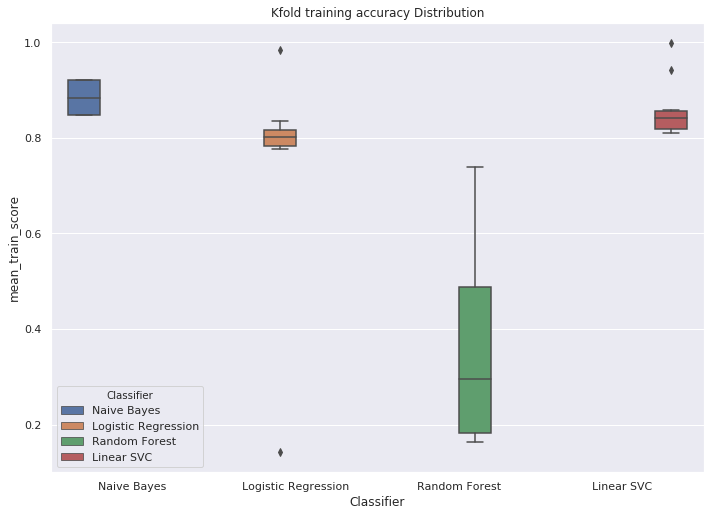

In [67]:
# Train Accuracy {'mean_train_score'}
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax = plt.subplots(1,1)
ax = sns.boxplot(y="mean_train_score", x="Classifier", data=MergedResults, hue="Classifier")
plt.title('Kfold training accuracy Distribution')

Text(0.5,1,'10 Kfold test accuracy Distribution')

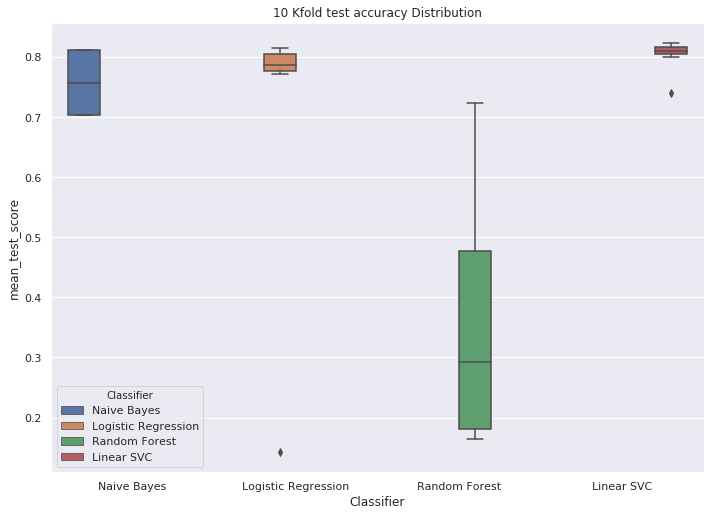

In [68]:
# Test Accuracy {'mean_test_score'}
ax = sns.boxplot(y='mean_test_score', x="Classifier", data=MergedResults, hue="Classifier")
plt.title('10 Kfold test accuracy Distribution')

In [69]:
# Train vs Test Accuracy {'mean_test_score'}
from pandas.tools.plotting import table
cm = sns.light_palette("blue", as_cmap=True)
summary = pd.DataFrame(MergedResults.groupby(['Classifier'])['mean_test_score'].agg(['max','mean', 'median','std']))
s = summary.style.background_gradient(cmap=cm)
s

,max,mean,median,std
Classifier,,,,
Linear SVC,0.822965,0.804455,0.809952,0.0235719
Logistic Regression,0.814334,0.727041,0.786085,0.205768
Naive Bayes,0.810977,0.757487,0.757487,0.0617646
Random Forest,0.722961,0.349819,0.292646,0.198683


Linear SVC with an accuracy of `82.3%` is edges Logistic regression `81.43%`  where as  Naive Bayes `81%` come third. 

Linear SVC is choosen because of its accuracy.

Below  I show the accuracy of the best hyper paramaters for the three classifiers  SVC, Logistic regression and NaiveBayes.

### Test Accuracy

In [72]:
# fit best performing models
best_svm_clf = LinearSVC().set_params(**svc_clf_cv.best_params_).fit(X_train_tfidf, labels) #unpack and fit hyper parms
best_lr_clf = LogisticRegression().set_params(**lr_clf_cv.best_params_).fit(X_train_tfidf, labels)
best_nb_clf = MultinomialNB().set_params(**nb_clf_cv.best_params_).fit(X_train_tfidf, labels)

In [73]:
%%time
# SVM
predictor = lambda x:best_svm_clf.predict(count_vect.transform([" ".join(x)]))
svm_predictions = [predictor(x) for x in X_test.FinalCorpus]
print("svm Test Accuracy")
print('Test Accuracy Score :', accuracy_score(y_test,svm_predictions) )

svm Test Accuracy
Test Accuracy Score : 0.7932337106659643
CPU times: user 10.5 s, sys: 14.1 ms, total: 10.5 s
Wall time: 10.5 s


In [74]:
## save model for future use

In [75]:
filename = 'finalized_model.sav'
pickle.dump(best_svm_clf, open( "setups/"+filename, "wb" ) , protocol=2) # save list as pickle

In [76]:
# save the model to disk
filename = 'finalized_LinearSVC_model.sav'
joblib.dump(best_svm_clf , "setups/"+filename)

['setups/finalized_LinearSVC_model.sav']

In [77]:
%%time
# Naive Bayse Accuracy
predictor = lambda x:best_nb_clf.predict(count_vect.transform([" ".join(x)]))
nb_predictions = [predictor(x) for x in X_test.FinalCorpus]
print("Naive Bayse Test Accuracy")
print('Test Accuracy Score :', accuracy_score(y_test,nb_predictions) )

Naive Bayse Test Accuracy
Test Accuracy Score : 0.8000308376270446
CPU times: user 22.8 s, sys: 19.1 ms, total: 22.8 s
Wall time: 22.8 s


In [78]:
%%time
# Logistic Regression
predictor = lambda x:best_lr_clf.predict(count_vect.transform([" ".join(x)]))
lr_predictions = [predictor(x) for x in X_test.FinalCorpus]
print("Logistic Regression Test Accuracy")
print('Test Accuracy Score :', accuracy_score(y_test,lr_predictions) )

Logistic Regression Test Accuracy
Test Accuracy Score : 0.7832500289102754
CPU times: user 10.4 s, sys: 9.47 ms, total: 10.4 s
Wall time: 10.4 s


### Linear SVC Model Evaluation

In [79]:
# Confusion matrix

In [80]:
from sklearn.metrics import confusion_matrix

In [81]:
confusion_mat = confusion_matrix(y_test, nb_predictions)

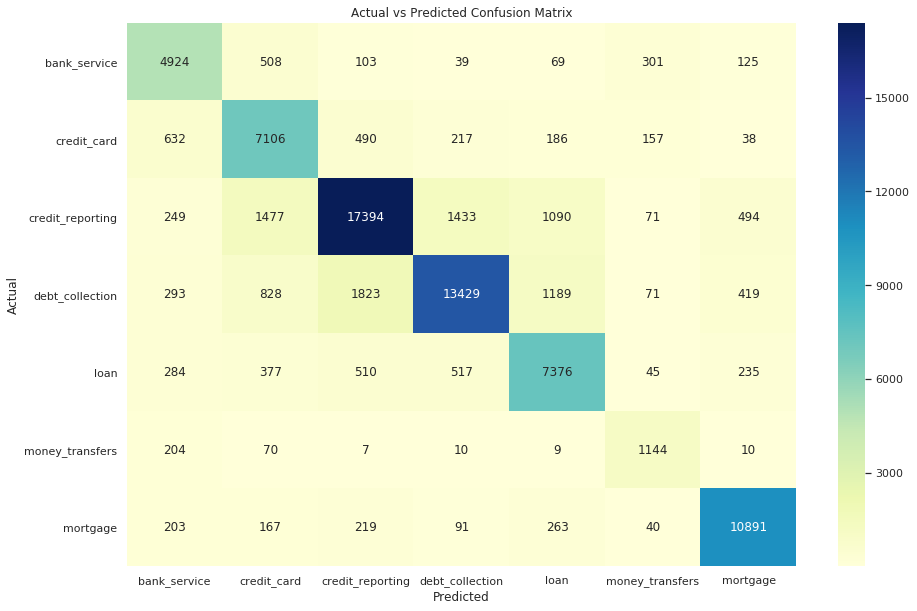

In [82]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(confusion_mat, annot=True, fmt='d',cmap="YlGnBu",
            xticklabels=ProductMapper.values(), yticklabels=ProductMapper.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Actual vs Predicted Confusion Matrix')
plt.show()

In an ideal scenerio all the observations would fall in the diagonal axis indicating correct class predictions. Our model works great, Majority of the complaints fall on the diagonal axis indicating correct predicted Product Group for majority of the Customer complaints i.e. Predicted label matches the true label. There is significant overlap between credit reporting, debt collection , credit card and loans as demonstated by the significant missclassification in this classes

In [83]:
# Accuracy by class

In [84]:
from sklearn import metrics
print(metrics.classification_report(y_test, nb_predictions, target_names=ProductMapper.values()))

                  precision    recall  f1-score   support

    bank_service       0.73      0.81      0.77      6069
     credit_card       0.67      0.81      0.73      8826
credit_reporting       0.85      0.78      0.81     22208
 debt_collection       0.85      0.74      0.79     18052
            loan       0.72      0.79      0.76      9344
 money_transfers       0.63      0.79      0.70      1454
        mortgage       0.89      0.92      0.90     11874

       micro avg       0.80      0.80      0.80     77827
       macro avg       0.76      0.81      0.78     77827
    weighted avg       0.81      0.80      0.80     77827



Ideally, a classifier with high recall and high precision is what we seek.

### Feature importance

ran out of time to implement this section. This would have been used to evaluate features that the classifier uses to make it's classification. This is critical in the evaluation of the model performance.

In [88]:
#Model explainbility
import shap

In [89]:
# print the JS visualization code to the notebook
shap.initjs()

In [97]:
def convert(list): 
    '''
    Convert to string
    '''
      
    # Converting integer list to string list 
    content = [str(i) for i in list] 
      
    return(content) 

In [104]:
corpus = X_RUS
y = y_RUS

In [105]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(convert(corpus_train))
X_test = vectorizer.transform(convert(corpus_test))

In [192]:
model = LogisticRegression().set_params(**lr_clf_cv.best_params_).fit(X_train, y_train)

In [193]:
mapper = list(ProductMapper.values())
FeatureNames = vectorizer.get_feature_names()

Feature importance and impact to Class prediction


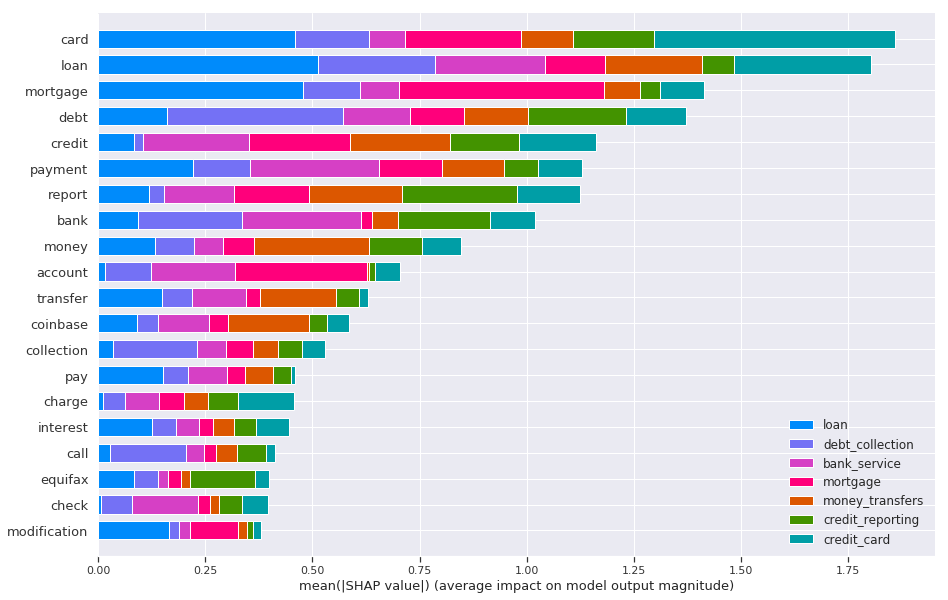

In [196]:
def FeatureImportance(model, df_Train, df_test, ShapExplainer,mapper, FeatureNames ): 
    '''
    Function to plot feature importance and impact to prediction using shap library
    inputs:
    model = fitted model
    df_Train = Training Dataset
    df_Test = Test Dataset
    ShapExplainer = Type of shap model explainer to use  eg shap.LinearExplainer
    mapper = class labels list
    FeatureNames =List of feature names in the dataset
    
    '''
    fig, ax = plt.subplots(figsize=(15,10))

    explainer = ShapExplainer(model, df_Train)#, feature_dependence="independent")
    shap_values = explainer.shap_values(df_test)
    X_test_array = df_test.toarray() # we need to pass a dense version for the plotting functions

    print('Feature importance and impact to Class prediction')
    shap.summary_plot(shap_values, df_test, feature_names=FeatureNames,
                      auto_size_plot=False,
                      class_names =mapper)

FeatureImportance(model, X_train,X_test,shap.LinearExplainer, mapper, FeatureNames )

Above bar plot list the top 20 important features and their contribution to the models classficatiion to the different business groups

### Model Deployment and Predict

In [141]:
X =modelingdata.text[100]
X

"Bank of America took money from my bank account for a 2014 debt without notifying me. The debt occurred as a result of the bank 's negligence in not having a business continuity plan. They failed to close their XXXX office despite warnings of a severe snow storm. As a result, I was stranded for over 21 hours on the interstate. As a result of that calamity, I was hospitalized at XXXX receiving XXXX. The Bank further damaged me by not approving my leave and I did n't receive a paycheck while out on leave. This caused my account to become overdrawn. By the time I appealed and fought the decision not to pay me, my account had been closed. At no time did the bank give me an opportunity to try and settle this debt. Instead, they waited 2 years to take money from my account without warning. Bank of America has a history of abusing the elderly and XXXX veterans."

In [143]:

import pickle
from spacy_normalizer import *

def predict(rawtext):
    '''
    Function takes in a classfication object 
    and returns the predicted product group
    
    # fitted classification object
    
    '''
    
    text = SpacyTextCleaner(rawtext, stoplist = ['XX', 'XXXX', 'XXX'])
    #load productgroup mapper
    with open('setups/ProductGroupMapper.p', 'rb') as f:
        ProductMapper= pickle.load(f)
        
    #load pickled trained model
    with open('setups/finalized_model.sav', 'rb') as f:
        clf= pickle.load(f)
    #load pickled Vocab
    with open('setups/count_vect.p', 'rb') as f:
        count_vect= pickle.load(f)
    print("")
    print('***** Customer Complaint entered ****')
    print(rawtext)
    print(" ")
    prediction = ProductMapper[(clf.predict(count_vect.transform([" ".join(text)])))[0]]
    print('**** Predictiction ****')
    return prediction



In [145]:

customer_complaint = input("Enter customer complaint: \n")

print("Predicted Product Group:", predict(customer_complaint))

Enter customer complaint: 
Bank of America took money from my bank account for a 2014 debt without notifying me. The debt occurred as a result of the bank 's negligence in not having a business continuity plan. They failed to close their XXXX office despite warnings of a severe snow storm. As a result, I was stranded for over 21 hours on the interstate. As a result of that calamity, I was hospitalized at XXXX receiving XXXX. The Bank further damaged me by not approving my leave and I did n't receive a paycheck while out on leave. This caused my account to become overdrawn. By the time I appealed and fought the decision not to pay me, my account had been closed. At no time did the bank give me an opportunity to try and settle this debt. Instead, they waited 2 years to take money from my account without warning. Bank of America has a history of abusing the elderly and XXXX veterans.

***** Customer Complaint entered ****
Bank of America took money from my bank account for a 2014 debt wit

In [79]:
%load_ext version_information
%version_information pandas, numpy, unipath, sklearn, matplotlib, pickle, collections,warnings, seaborn

Software,Version
Python,3.6.8 64bit [GCC 7.3.0]
IPython,7.2.0
OS,Linux 4.15.0 51 generic x86_64 with debian buster sid
pandas,0.24.2
numpy,1.16.2
unipath,1.1
sklearn,0.20.3
matplotlib,2.2.2
pickle,The 'pickle' distribution was not found and is required by the application
collections,The 'collections' distribution was not found and is required by the application
